In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import differential_evolution

In [2]:
#colors
DARK_RED = '#b30000'
RED = '#ff0000'
GRAY = '#bfbfbf'
BLUE = '#4d94ff'
DARK_BLUE = '#0066ff'

## Notes
- #### For now we're using four political classes
    - Democrat - D Lean - R Lean - Republican
    - use code [0, 1, 1, 0] for moderate
- #### Assumptions:
    - For media consumption frequency: the persuasion only happens when you read the whole article, not just the headline
    
    
- #### Social media is polarizing. We might need television, newspaper, and online news data, or we group those all under their orgs. Can ignore local news for now. Radio we can just use Hannity and Limbaugh. 



## Links
- Media Sources by Dem/Rep: https://www.journalism.org/2020/01/24/americans-are-divided-by-party-in-the-sources-they-turn-to-for-political-news/
- Most common platform for news by Dem/Rep: https://www.journalism.org/2020/01/24/election-news-pathways-project-frequently-asked-questions/#ideological-composition-of-news-outlets-audiences
- News from social media 2021: https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
- Number of sources by Dem/Rep: https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
- News from social media 2020: https://www.journalism.org/2020/07/30/americans-who-mainly-get-their-news-on-social-media-are-less-engaged-less-knowledgeable/
- Most common platform by Dem/Rep: https://www.pewresearch.org/pathways-2020/NEWS_MOST/political_party/us_adults
- Paper about Social Media and news consumption: https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.20191777
- Daily news consumption: https://www.americanpressinstitute.org/publications/reports/survey-research/americans-news-consumption/

In [3]:
#make media classes
class MediaOutlet:
    def __init__(self, name, political_leaning, mcb_ideology):#, mcb_education, mcb_age)
        self.name = name
        self.political_leaning = political_leaning#[dem, Dlean, mod, Rlean, rep]  0 or 1 by what media place is
        
        #Media Consumption by...
        self.mcb_ideology = mcb_ideology#[dem, Dlean, Rlean, rep]  % of that group that consumes
        #self.mcb_education #[college +, some college, HS -]  % of that group that consumes
        #self.mcb_age # [18-49, 50+]  % of that group that consumes
    
    def __str__(self):
        return self.name
     
    def get_value(self):
        values = [-1, -0.5, 0, 0.5, 1]
        return values[self.political_leaning.index(1)]
#     def __add__(self, other):
        
    

In [4]:
#make agent class
class Agent:
    def __init__(self, approval, ideology, approval_value):
        self.media_consumption = []
        self.consumption_rate = 0

        #demographic information
        self.approval = approval
        self.ideology = ideology
        
        self.approval_value = approval_value
        
        #self.neg_persuadability = abs(1 - approval_value)/2
        #self.pos_persuadability = abs(-1 - approval_value)/2
        
        denom = np.exp(2)-1
        self.neg_persuadability = (np.exp(-approval_value+1)-1)/denom
        self.pos_persuadability = (np.exp(approval_value+1)-1)/denom
        
        self.uses_social_media = False
        
        self.late_night = 0
       
    
    def assign(self, media_outlet):
        self.media_consumption.append(media_outlet)
        
        
    def stats(self):
        print(f'Ideology: {self.ideology}\nApproval: {self.approval}')

        print('\tMedia Sources: ', end='')
        for m in self.media_consumption:
            print(m, end=', ')
        
        print(f'\n\tConsumption Frequency: {self.consumption_rate}', end='')
        
        oftenness = ['Never', 'Less than Once a Month', 'About Once a Month', 'Several Times a Month', 'Once a Week', 'Multiple Times A Week']
        print(f'\nWatches Late-Night: {oftenness[self.late_night]}')
            
    def consume_media(self):
        #return all the media the was conusmed this step
            #perhaps the raw value
        return [m.get_value() for m in self.media_consumption]

In [5]:
class Model:
    def __init__(self, num_agents, political_distribution, approval_matrix, media_array, distribution_threshold=0.1, platform_split=[[], []], use_late_night=False):
                                                                                                                    # %dem, %rep who use social media for news
        self.political_distribution = political_distribution 
            #[%, %, %] (for now, [D, R, indep])distrib of agents ideologies
            
        self.approval_matrix = np.array(approval_matrix)
        
            #[Dem, Rep, Ind] by [strongly app, somewhat app, somewhat disapp, strongly disapp, no approval]
                #matrix 
        
        self.media_array = media_array 
            #array of MediaOutlet objects to loop through
        
        self.platform_split = platform_split
        
        self.use_late_night = use_late_night
        #parameters
#         self.threshold = threshold
#         self.alpha = alpha
        
        #make the agents
        self.agents = [None]*num_agents
        self.agent_approval_values = np.zeros((num_agents, ))
        self.agent_political_ids = np.zeros((num_agents, 4))
        
        self.generate_agents(num_agents, distribution_threshold)
        
        self.starting_state = self.agent_approval_values.copy()
        self.starting_agent_op = [str(agent.approval) for agent in self.agents]
        
        
    def generate_agents(self, num_agents, distribution_threshold):
        #initialize agents with ideology and approval
            #approval is a continuous value normally distributed around the 4 poles within some threshold
        
        
        distribution = np.round(self.approval_matrix * self.political_distribution * num_agents / 10000)
        #other = num_agents - np.sum(distribution)
        
        current_agent = 0
        approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
        self.approval_types = np.array(approval_types)
        approval_values = [1, 0.5, -0.5, -1, 0]
        party_types = ["democrat", 'republican', 'independent']
        politcal_ids = [[[1, 0, 0, 0], [0, 1, 0, 0]],
                        [[0, 0, 1, 0], [0, 0, 0, 1]],
                        [[0, 1, 0, 0], [0, 0, 1, 0]]]
        random_choices = np.random.randint(low=0, high=2, size=(num_agents,))
        for index, approval_row in enumerate(distribution):
            for party_index, amount in enumerate(approval_row):
                amount = int(amount)
                #normal distribution within threshold of the index 
                
                self.agent_approval_values[current_agent:current_agent+amount] = np.random.normal(approval_values[index], distribution_threshold/3, (amount,)) 
                '''The party IDs are chosen randomly within each party, where the intensity of approval values should probably dictate if someone is lean left versus far left
                        - or maybe not, since this is conflating Trump approval with party alignment. 
                        - a lean left person may hate trump, while a far left may approve of him slightly more'''
                self.agent_political_ids[current_agent:current_agent+amount] =  [politcal_ids[party_index][val] for val in random_choices[current_agent:current_agent+amount]]
                
                self.agents[current_agent:current_agent+amount] = [Agent(approval_types[index], party_types[party_index], self.agent_approval_values[current_agent+i]) for i in range(amount)]
                current_agent += amount

        
        #calculate the needed assignments to reach the percentages
        
        approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents[:current_agent]], bins=len(self.approval_types))[0]
        
        #force this for now
        target = [.44, .52] #app, dis
        a = (approvals[0] + approvals[1])/len(self.agents)
        d = (approvals[2] + approvals[3])/len(self.agents)
        
        need_app = int((target[0] * num_agents) - (a * num_agents))
        need_dis = int((target[1] * num_agents) - (d * num_agents))
        
        for i in range(current_agent, current_agent+need_app):
            #choose from 0, 1 approval
            approval_choice = np.random.choice([0, 1])
            party_choice = np.random.choice([0, -1])
            self.agent_approval_values[i] = np.random.normal(approval_values[approval_choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[approval_choice], party_types[party_choice], self.agent_approval_values[i])
            
        current_agent += need_app
        
        for i in range(current_agent, current_agent+need_dis):
            #choose from 0, 1 approval
            approval_choice = np.random.choice([2, 3])
            party_choice = np.random.choice([1, -1])
            self.agent_approval_values[i] = np.random.normal(approval_values[approval_choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[approval_choice], party_types[party_choice], self.agent_approval_values[i])
            
        current_agent += need_dis
        
        
        #make the rest of them no opinion
        for i in range(current_agent, num_agents):
            choice = 4
            party_choice = np.random.choice([0, 1, 2])
            self.agent_approval_values[i] = np.random.normal(approval_values[choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[choice], party_types[party_choice], self.agent_approval_values[i])
            
        
        self.assign_media()
        if self.use_late_night:
            self.assign_late_night()

            
            
    def assign_late_night(self):
        '''Watch Late Night? HR1_1 by PID
              Yes.   No
        Dem   54.    46
        Ind   34.    66
        Rep   26.    74


        How often? (Of those who said yes) HR2 by PID
              Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
        Dem.     51             18.           15.            5.               6.            5
        Ind      35.            17.           22.            10.              9.            7
        Rep      35.            18.           20             10               12            5
        
        
        Interpret as
            Mult/week    4 days per week on average? -> 3/7 chance per day
            Once/Week    2/7 chance per day
            Mult/month   less than 4 times a month so 3 times? -> 1/10 a day
            Once/month   2/30 chance per day
            <once/month  0.8/30 chance maybe? 
            Never        small chance or no chance?
        '''
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        inds = np.where(pids == 'independent')[0]
        reps  = np.where(pids == 'republican')[0]

        #from above polling
        dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
        inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
        reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

        LN_dems = np.where(dems_watch_LN)[0]
        LN_inds = np.where(inds_watch_LN)[0]
        LN_reps = np.where(reps_watch_LN)[0]

        LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
        LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
        LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .18, .20, .10, .12, .05])

        for d in LN_dems: self.agents[d].late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
        for i in LN_inds: self.agents[i].late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
        for r in LN_reps: self.agents[r].late_night = LN_reps_watch_amount[list(LN_reps).index(r)]


    
    def assign_media(self):
        dems = np.where((self.agent_political_ids == [1, 0, 0, 0]).all(axis=1) | (self.agent_political_ids == [0, 1, 0, 0]).all(axis=1) )[0]
        reps = np.where((self.agent_political_ids == [0, 0, 0, 1]).all(axis=1) | (self.agent_political_ids == [0, 0, 1, 0]).all(axis=1) )[0]
        
        for media in self.media_array:
            #the number of dems and reps that conusme this media
            to_consume = [0, 0]
            to_consume[0] = int(np.round(media.mcb_ideology[0] * len(dems) / 100))
            to_consume[1] = int(np.round(media.mcb_ideology[-1] * len(reps) / 100))
        
            dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
            rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
            
            for ind in dem_agent_indices:
                self.agents[ind].assign(media)
                
            for ind in rep_agent_indices:
                self.agents[ind].assign(media)
                
                
        
        #Social Media        
        to_consume = [0, 0]
        to_consume[0] = int(np.round(self.platform_split[0][1] * len(dems) / 100))
        to_consume[1] = int(np.round(self.platform_split[1][1] * len(reps) / 100))
        dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
        rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
        
        for ind in dem_agent_indices:
            self.agents[ind].uses_social_media = True
        for ind in rep_agent_indices:    
            self.agents[ind].uses_social_media = True   
            
        
        
        #Consumption Rate
        '''
        Those that closely read an article or watch a program
        More    Once    Less    Never     in a day
        39% 	29% 	30% 	2%
         |       |       |      |
         V       V       V      V
        1.5      1       .5     0         percentages * 100        
        '''
        rates = np.random.choice([1.5, 1, 0.5, 0], len(self.agents), p=[.39, .29, .3, .02])

        for ind, r in enumerate(rates):
            self.agents[ind].consumption_rate = r
            
        
        
        
        
    def simulate(self, steps, draw=False, optimize=False, use_randomness=False, threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, late_night_const=-1, late_night_jokes=0, use_starting_agents=False):
        if optimize or use_starting_agents:
            self.agent_approval_values = self.starting_state.copy()
            for i, agent in enumerate(self.agents):
                agent.approval = self.starting_agent_op[i]
                agent.neg_persuadability = abs(1 - self.agent_approval_values[i])/2
                agent.pos_persuadability = abs(-1 - self.agent_approval_values[i])/2
            
        starting_value = np.average(self.agent_approval_values)
        starting_approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
        starting_polls = [(starting_approvals[0] + starting_approvals[1])/10, (starting_approvals[2] + starting_approvals[3])/10]
        
        #this needs to match approval types
        media_values = np.array([1, 0.5, -0.5, -1, 0])
        
        
        polling_history = np.zeros((steps+1, 2))
        polling_history[0] = starting_polls
        
        for current_step in range(steps):
            for i, agent in enumerate(self.agents):
                second_rate = 0
                rate = 0
                if agent.consumption_rate < 1:
                    rate = agent.consumption_rate 
                elif agent.consumption_rate > 1:
                    rate = 1
                    second_rate = agent.consumption_rate - 1
                
                will_consume = np.random.choice([True, False], p=[rate, 1-rate])
                
                while will_consume:
                    try:
                        value = np.random.choice(agent.consume_media())
                    except:
                        break
                    #if np.random.choice([True, False], p=[rate, 1-rate]):
                    #kernel = (value + coverage_leaning)/2 - self.agent_approval_values[i]
                    kernel = value + coverage_leaning - self.agent_approval_values[i]
                    if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                        #change persuadability in opposite direction


                        if value > 0:
                            agent.neg_persuadability -= abs(kernel) * persuadability_scale
                            if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                            if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                        elif value < 0:
                            agent.pos_persuadability -= abs(kernel) * persuadability_scale
                            if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                            if agent.pos_persuadability > 1: agent.pos_persuadability = 1


                    #'''change here to make 0-biased news sources do something'''
                    #else:
                    elif value != 0:
                        p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                        self.agent_approval_values[i] += p*kernel*alpha

                    
                    will_consume = np.random.choice([True, False], p=[second_rate, 1-second_rate])
                        
                        
                #now do social media
                if agent.uses_social_media:
                    p = agent.pos_persuadability if self.agent_approval_values[i] > 0 else agent.neg_persuadability
                    x = abs(self.agent_approval_values[i])
                    const = (1-x)/(2*x+1)
                    const *= social_media_const
                    self.agent_approval_values[i] += np.sign(self.agent_approval_values[i])*const * p


                if self.use_late_night:
                    #arbitrary percents from 0 to 6
                    percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                    #also arbitrary amount?
                    value = late_night_const
                    if (use_randomness and np.random.choice([True, False], p=[percents[agent.late_night], 1-percents[agent.late_night]])) or (not use_randomness):
                        kernel = (late_night_const * late_night_jokes) - self.agent_approval_values[i]
                        if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                            #change persuadability in opposite direction


                            if value > 0:
                                agent.neg_persuadability -= abs(kernel) * persuadability_scale
                                if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                                if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                            elif value < 0:
                                agent.pos_persuadability -= abs(kernel) * persuadability_scale
                                if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                                if agent.pos_persuadability > 1: agent.pos_persuadability = 1

                        else:#if value != 0:
                            p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                            self.agent_approval_values[i] += p*kernel

                w = np.where((self.agent_approval_values[i] < (media_values + threshold)) & (self.agent_approval_values[i] > (media_values - threshold)))[0]
                
                if len(w):
                    agent.approval = self.approval_types[w][0]

            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]

            polling_history[current_step+1] = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
                
            
            if draw:             
                clear_output(wait=True)
                plt.figure(figsize=(15, 7))
                #plt.ylim([25, 75])
                plt.xlim([0, steps-1])
                plt.subplot(211)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 0], label='Approval', linestyle='--', marker='o', color='orange')
                plt.legend()
                plt.subplot(212)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 1], label='Disapproval', linestyle='--', marker='o', color='blue')
                plt.legend()
                plt.show()
#                 plt.figure(figsize=(15, 5))
#                 plt.subplot(121)
#                 plt.hist(self.agent_approval_values, bins=100)
#                 plt.xlabel("Agents approval Value")
#                 plt.ylabel("Number of Agents")
                
#                 plt.subplot(122)
#                 o = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]/len(self.agents)*100
                
#                 h = plt.bar(range(len(o)), o)#plt.hist([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))
#                 h[0].set_color(DARK_RED)
#                 h[1].set_color(RED)
#                 h[2].set_color(BLUE)
#                 h[3].set_color(DARK_BLUE)
#                 h[4].set_color(GRAY)
#                 plt.ylabel("Percentage of Responses")
#                 plt.xticks(range(len(o)), self.approval_types, rotation='vertical')
#                 plt.show()
                
        if not optimize:
            print(f'Average approval: {starting_value} -> {np.average(self.agent_approval_values)}')


            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
            percents = [f'\n\t{self.approval_types[i]}: {100*starting_approvals[i] / len(self.agents)} -> {100*approvals[i] / len(self.agents)}%' for i in range(len(self.approval_types))]
            print("\nApproval Percentages: ", *percents)

            polls = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
            print(f"\nOverall Polling Change Predicted:\n\tApprove: {starting_polls[0]}% -> {polls[0]}%\n\tDisapprove: {starting_polls[1]}% -> {polls[1]}%")


        
        if optimize:
            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
            #returns approval
            
            return [100*(approvals[0]+approvals[1])/len(self.agents), 100*(approvals[2]+approvals[3])/len(self.agents), 100*approvals[4]/len(self.agents)]
            #return approvals / 10
            
       
    
        return polling_history
        
    
    def stats(self):
        pass
        
        
        
    def new_media_landscape(self):
        plt.figure(figsize=(15, 5))
        major = np.zeros((len(self.media_array)+1, ))
        minor = np.zeros((len(self.media_array)+1, ))
        
        
        for agent in self.agents:
            for media in agent.major_sources:
                if media == 'Social Media':
                    major[-1] += 1
                else:
                    major[self.media_array.index(media)] += 1
            
            for media in agent.minor_sources:
                if media == 'Social Media':
                    minor[-1] += 1
                else:
                    minor[self.media_array.index(media)] += 1
                
        N = len(self.media_array)+1

        ind = np.arange(N)  # the x locations for the groups
        width = 0.35       # the width of the bars

        fig, ax = plt.subplots(figsize=(15, 7))
        rects1 = ax.bar(ind, major, width)

        rects2 = ax.bar(ind + width, minor, width)

        # add some text for labels, title and axes ticks
        ax.set_ylabel('Number of Agents')
        ax.set_title('Major and Minor sources of media consumption')
        ax.set_xticks(ind + width / 2)
        ax.set_xticklabels([media.name for media in self.media_array]+['Social Media'], rotation='vertical')

        ax.legend((rects1[0], rects2[0]), ('Major Source', 'Minor Source'))


        def autolabel(rects):
            """
            Attach a text label above each bar displaying its height
            """
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                        '%d' % int(height),
                        ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.show()
        
        plt.figure(figsize=(15, 7), facecolor='white')
        plt.subplot(121)
        leanings = ['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right']
        ma = np.zeros((len(leanings), ))
        for i, media in enumerate(self.media_array):
            ma[media.political_leaning.index(1)] += major[i]

        plt.pie(ma, labels=leanings, autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        plt.title("Major Source Consumption")
        
        plt.subplot(122)
        mi = np.zeros((len(leanings), ))
        for i, media in enumerate(self.media_array):
            mi[media.political_leaning.index(1)] += minor[i]

        plt.pie(mi, labels=leanings, autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        plt.title("Minor Source Consumption")
        plt.show()
        
        
        
        
        
        
        
    
    def media_landscape(self):
        #describe how the media outlets inputted are distributed politcally and how many people watch them
        #x is leaning, y is number of agents that use it
        
        plt.figure(figsize=(15, 5))
        y = np.zeros((len(self.media_array), ))
        
        for agent in self.agents:
            for media in agent.media_consumption:
                y[self.media_array.index(media)] += 1
        plt.subplot(121)
        plt.bar(range(len(self.media_array)), y, label=[media.name for media in self.media_array])
        plt.xticks(ticks=range(len(self.media_array)), labels=[media.name for media in self.media_array], rotation='vertical')
        plt.xlabel("Media Outlets")
        plt.ylabel("Number of Agents")
        
        leanings = ['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right']
        yy = np.zeros((len(leanings), ))
        for i, media in enumerate(self.media_array):
            yy[media.political_leaning.index(1)] += y[i]
        plt.subplot(122)
        
            
        
        plt.pie(yy, labels=leanings, autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        plt.title("Media Political Leanings")
        
        #plt.pie(np.histogram([media.political_leaning.index(1) for media in self.media_array], bins=len(self.media_array[0].political_leaning))[0], labels=['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right'], autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        #plt.title("Media Political Leanings")
        plt.show()
        
        

In [6]:
                    '''political_leaning, mcb_ideology'''
CNN = MediaOutlet("CNN", [1, 0, 0, 0, 0], [53, 53, 24, 24])
MSNBC = MediaOutlet("MSNBC", [1, 0, 0, 0, 0], [33, 33, 14, 14])
HuffPost = MediaOutlet("HuffPost", [1, 0, 0, 0, 0], [12, 12, 3, 3])
#BuzzFeed = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [9, 9, 5, 5])
#Vox = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [8, 8, 1, 1])


#changed these to moderate
NBC = MediaOutlet("NBC", [0, 0, 1, 0, 0], [40, 40, 28, 28])
ABC = MediaOutlet("ABC", [0, 0, 1, 0, 0], [37, 37, 30, 30])
CBS = MediaOutlet("CBS", [0, 0, 1, 0, 0], [33, 33, 26, 26])


WashingtonPost = MediaOutlet("Washington Post", [0, 1, 0, 0, 0], [26, 26, 8, 8])
NewYorkTimes = MediaOutlet("New York Times", [0, 1, 0, 0, 0], [31, 31, 9, 9])
Politico = MediaOutlet("Politico", [0, 1, 0, 0, 0], [14, 14, 5, 5])
Time = MediaOutlet("Time", [0, 1, 0, 0, 0], [10, 10, 4, 4])
TheGuardian = MediaOutlet("The Guardian", [0, 1, 0, 0, 0], [8, 8, 3, 3])


NPR = MediaOutlet("NPR", [0, 0, 1, 0, 0], [30, 30, 11, 11])
BBC = MediaOutlet("BBC", [0, 0, 1, 0, 0], [22, 22, 10, 10])
WallStreetJournal = MediaOutlet("Wall Street Journal", [0, 0, 1, 0, 0], [15, 15, 11, 11])
USAToday = MediaOutlet("USA Today", [0, 0, 1, 0, 0], [13, 13, 10, 10])
TheHill = MediaOutlet("The Hill", [0, 0, 1, 0, 0], [8, 8, 5, 5])
Newsweek = MediaOutlet("Newsweek", [0, 0, 1, 0, 0], [7, 7, 3, 3])

#added cable since there is a difference
FoxNewsTV = MediaOutlet("Fox News Cable", [0, 0, 0, 1, 0], [23, 23, 60, 60])
NewYorkPost = MediaOutlet("New York Post", [0, 0, 0, 1, 0], [5, 5, 5, 5])
WashingtonExaminer = MediaOutlet("WashingtonExaminer", [0, 0, 0, 1, 0], [2, 2, 4, 4])

FoxNews = MediaOutlet("Fox News", [0, 0, 0, 0, 1], [23, 23, 60, 60])
Hannity = MediaOutlet("Hannity", [0, 0, 0, 0, 1], [1, 1, 19, 19])#made up
Limbaugh = MediaOutlet("Limbaugh", [0, 0, 0, 0, 1], [1, 1, 17, 17])#made up
Breitbart = MediaOutlet("Breitbart", [0, 0, 0, 0, 1], [0.5, 0.5, 8, 8])
DailyCaller = MediaOutlet("Daily Caller", [0, 0, 0, 0, 1], [0.5, 0.5, 3, 3])


media_outlets = [CNN, MSNBC, HuffPost, #BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, FoxNewsTV, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

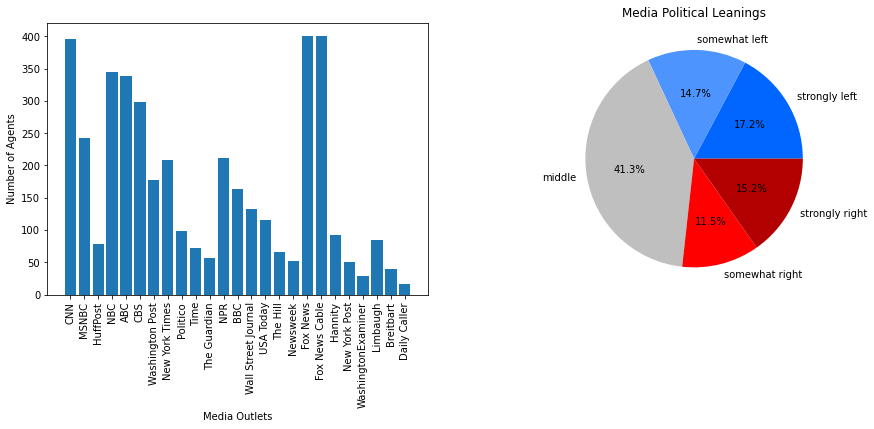

In [7]:
'''
2/17/20 WP-ABC poll [29, 25, 37], 
[[2,	76,	27],
[2, 12,	19],
[11,	6,	14],
[84,	5,	34],
[1, 	2,	6]]
'''

'''
3/25/20 WP-ABC poll [30, 24, 37], 
[[6,	74,	30],
[11,	12,	19],
[13,	6,	12],
[65,	6,	33],
[5,	    2,	6]]
'''
#5/28/20 WP-ABC poll [31, 24, 37], [32, 12, 3, 11, 42]


''' total = [44, 52]
3/18/20 Ipsos poll [44, 37, 10],
[[5, 56, 14],
[8, 30, 23],
[18, 7, 21],
[67, 5, 32],
[2, 1, 10]]
'''
model = Model(1000, [44, 37, 10],
                [[5, 56, 14],
                [8, 30, 23],
                [18, 7, 21],
                [67, 5, 32],
                [2, 1, 10]], 
              media_outlets, distribution_threshold=0.5, platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], 
              use_late_night=True)

''' total = [42, 52, 6]
4/22/20 Ipsos poll [44, 37, 10],
[[3, 54, 17],
[6, 26, 17],
[14, 6, 17],
[73, 7, 39],
[4, 7, 10]]
'''

''' total = [41, 54, 5]
5/20/20 Ipsos poll [44, 37, 10],
[[4, 55, 12],
[4, 27, 20],
[11, 6, 17],
[76, 7, 34],
[5, 5, 17]]
'''


'''The given info should be where the model starts at'''
#Febuary
# model = Model(1000, [29, 25, 37], 
#             [[2,	76,	27],
#             [2,     12,	19],
#             [11,	6,	14],
#             [84,	5,	34],
#             [1, 	2,	6]], 
#               media_outlets, distribution_threshold=0.5)


#March
# model = Model(1000, [30, 24, 37], 
#                 [[6,	74,	30],
#                 [11,	12,	19],
#                 [13,	6,	12],
#                 [65,	6,	33],
#                 [5,	    2,	6]], 
#               media_outlets, distribution_threshold=0.25)

model.media_landscape()

In [8]:
r = np.random.randint(1000)
model.agents[r].stats()
model.agents[r].consume_media()

Ideology: democrat
Approval: strongly disapprove
	Media Sources: CNN, NBC, ABC, CBS, New York Times, Politico, NPR, USA Today, Fox News Cable, 
	Consumption Frequency: 1.5
Watches Late-Night: Never


[-1, 0, 0, 0, -0.5, -0.5, 0, 0, 0.5]

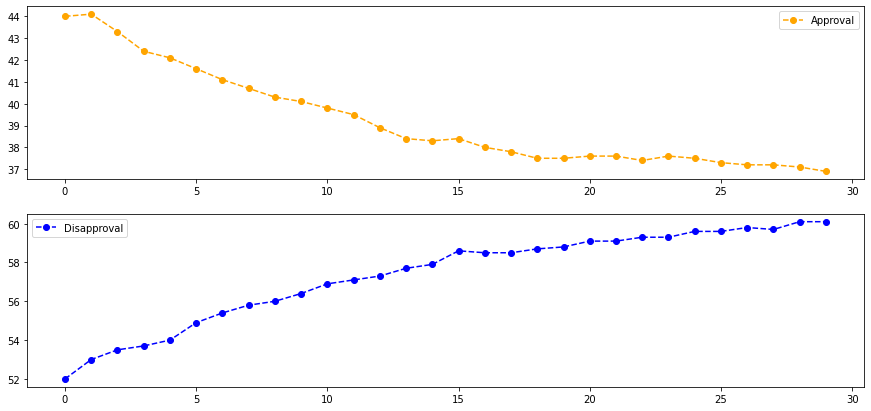

Average approval: -0.0962711597515044 -> -0.16253002952556908

Approval Percentages:  
	strongly approve: 25.5 -> 28.2% 
	somewhat approve: 18.5 -> 8.6% 
	somewhat disapprove: 15.3 -> 26.4% 
	strongly disapprove: 36.7 -> 33.6% 
	no opinion: 4.0 -> 3.2%

Overall Polling Change Predicted:
	Approve: 44.0% -> 36.8%
	Disapprove: 52.0% -> 60.0%


array([[44. , 52. ],
       [44.1, 53. ],
       [43.3, 53.5],
       [42.4, 53.7],
       [42.1, 54. ],
       [41.6, 54.9],
       [41.1, 55.4],
       [40.7, 55.8],
       [40.3, 56. ],
       [40.1, 56.4],
       [39.8, 56.9],
       [39.5, 57.1],
       [38.9, 57.3],
       [38.4, 57.7],
       [38.3, 57.9],
       [38.4, 58.6],
       [38. , 58.5],
       [37.8, 58.5],
       [37.5, 58.7],
       [37.5, 58.8],
       [37.6, 59.1],
       [37.6, 59.1],
       [37.4, 59.3],
       [37.6, 59.3],
       [37.5, 59.6],
       [37.3, 59.6],
       [37.2, 59.8],
       [37.2, 59.7],
       [37.1, 60.1],
       [36.9, 60.1],
       [36.8, 60. ]])

In [9]:
(threshold, alpha, persuadability_scale, social_media_const) = [0.37364163, 0.06361854, 0.4841436,  0.5254433 ]
late_night_const = -0.38006347
'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452

model.simulate(30, draw=True, coverage_leaning=0, use_randomness=True, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


In [ ]:
late_night_jokes = 4.8740165631469985
m.simulate(30, draw=True, coverage_leaning=-0.5, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

In [8]:
#give model class and args as a tuple
def optimize(m, polling_target, bounds, initial_guess):
    #polling target should be the target approval rating
    #use scipy optimize or minimize to fit threshold and alpha
    coverage_leaning = 0.05
    
    #first period
    late_night_jokes = 4.202088452088452
    late_night_const=0
    def f(x):
        (threshold, alpha, persuadability_scale, social_media_const) = x
        
        result = m.simulate(30, optimize=True, use_randomness=True, coverage_leaning=coverage_leaning, late_night_jokes=late_night_jokes,
                            threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
                            social_media_const=social_media_const, late_night_const=late_night_const)
        loss = 0
        for i, r in enumerate(result):
            loss += abs(r - polling_target[i])**2
        loss /= len(result)
        
        return loss

    opt = differential_evolution(f, bounds=bounds, strategy='best1bin', disp=True, maxiter=50)
    #(threshold, alpha, persuadability_scale) = opt.x
    #m.simulate(30, draw=True, optimize=True, threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning)
        
    print(f'{[r for r in opt.x]}')
    return opt.x
    
    
    
    #return 
    #return minimize(f, initial_guess, bounds=bounds, method='Nelder-Mead')



In [9]:
#try just 3 targets   approve, disapprove, no op[0.21903605 0.00097886 0.5318334  0.00372754]
target = [42, 52, 6]



bounds = [(0.005, 0.5), (0.0005, 0.1), (0.0001, 1), (0, 1)]#, (-1, 0)]
#initial_guess = [ 0.3894822,   0.09130128,  0.84938691,  0.55262656, -0.38006347]
initial_guess = [0.23987374747543097, 0.008196967677699105, 0.19082355480732427, 0.15832773350644436]

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

results = optimize(m, target, bounds, initial_guess)

differential_evolution step 1: f(x)= 0.56
differential_evolution step 2: f(x)= 0.56
differential_evolution step 3: f(x)= 0.56
differential_evolution step 4: f(x)= 0.56
differential_evolution step 5: f(x)= 0.56
differential_evolution step 6: f(x)= 0.56
differential_evolution step 7: f(x)= 0.56
differential_evolution step 8: f(x)= 0.56
differential_evolution step 9: f(x)= 0.56
differential_evolution step 10: f(x)= 0.56
differential_evolution step 11: f(x)= 0.56
differential_evolution step 12: f(x)= 0.56
differential_evolution step 13: f(x)= 0.56
differential_evolution step 14: f(x)= 0.56
differential_evolution step 15: f(x)= 0.56
differential_evolution step 16: f(x)= 0.56
differential_evolution step 17: f(x)= 0.56
differential_evolution step 18: f(x)= 0.56
differential_evolution step 19: f(x)= 0.406667
differential_evolution step 20: f(x)= 0.406667
differential_evolution step 21: f(x)= 0.406667
differential_evolution step 22: f(x)= 0.38
differential_evolution step 23: f(x)= 0.38
differen

# Late Night

In [81]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = results#[ 0.00629773  0.07550578  0.39019542  0.78456869 -0.02043869]

'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452


LN_period1 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=0.05, late_night_jokes=late_night_jokes, use_starting_agents=True,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


Average approval: -0.09812472092445626 -> -0.12165561797977614

Approval Percentages:  
	strongly approve: 25.7 -> 26.9% 
	somewhat approve: 18.3 -> 15.1% 
	somewhat disapprove: 15.5 -> 12.7% 
	strongly disapprove: 36.5 -> 39.4% 
	no opinion: 4.0 -> 5.9%

Overall Polling Change Predicted:
	Approve: 44.0% -> 42.0%
	Disapprove: 52.0% -> 52.1%


In [82]:
late_night_jokes = 4.8740165631469985
LN_period2 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=-0.25, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.12165561797977614 -> -0.209927973534907

Approval Percentages:  
	strongly approve: 26.9 -> 26.5% 
	somewhat approve: 15.1 -> 13.2% 
	somewhat disapprove: 12.7 -> 11.2% 
	strongly disapprove: 39.4 -> 41.9% 
	no opinion: 5.9 -> 7.2%

Overall Polling Change Predicted:
	Approve: 42.0% -> 39.7%
	Disapprove: 52.1% -> 53.1%


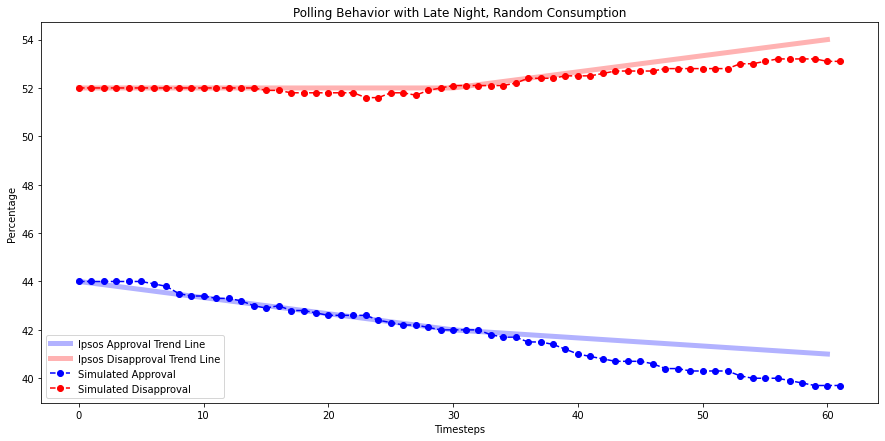

In [83]:
steps = range(62)
plt.figure(figsize=(15, 7))
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)

approval = np.concatenate((LN_period1, LN_period2))

plt.plot(steps, approval[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
plt.plot(steps, approval[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
plt.legend()
plt.show()

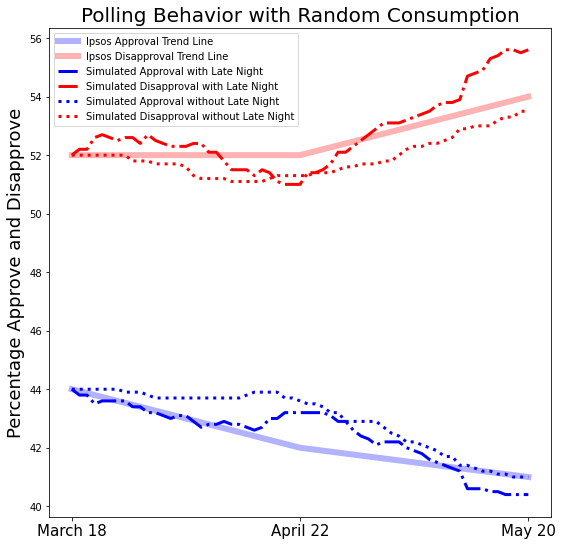

In [100]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Random Consumption", fontsize=20)
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=18)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)

LN = np.concatenate((LN_period1, LN_period2[1:]))
NLN = np.concatenate((NLN_period1, NLN_period2[1:]))

plt.plot(steps, LN[:, 0], label="Simulated Approval with Late Night", linestyle='-.',  color='blue', lw=3)
plt.plot(steps, LN[:, 1], label="Simulated Disapproval with Late Night", linestyle='-.',  color='red', lw=3)

plt.plot(steps, NLN[:, 0], label="Simulated Approval without Late Night", linestyle=':',  color='blue', lw=3)
plt.plot(steps, NLN[:, 1], label="Simulated Disapproval without Late Night", linestyle=':', color='red', lw=3)

plt.legend()
plt.show()

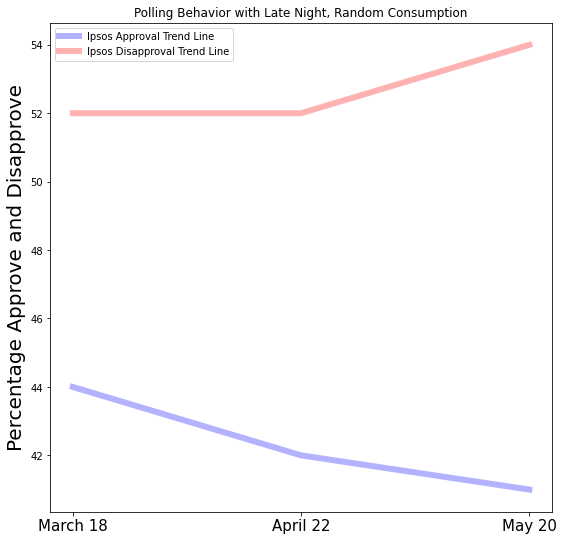

In [96]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Late Night, Random Consumption")
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=20)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)


plt.legend()
plt.show()

# No Late Night

In [133]:
(threshold, alpha, persuadability_scale, social_media_const) = results#[0.37364163, 0.06361854, 0.4841436,  0.5254433 ]

late_night_jokes = 4.202088452088452
late_night_const = 0

NLN_period1 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=0.25, late_night_jokes=late_night_jokes, use_starting_agents=True,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


Average approval: -0.1089896177164236 -> -0.09833004018667112

Approval Percentages:  
	strongly approve: 25.5 -> 28.2% 
	somewhat approve: 18.5 -> 14.4% 
	somewhat disapprove: 14.2 -> 11.8% 
	strongly disapprove: 37.8 -> 39.6% 
	no opinion: 4.0 -> 6.0%

Overall Polling Change Predicted:
	Approve: 44.0% -> 42.6%
	Disapprove: 52.0% -> 51.4%


In [134]:
late_night_jokes = 4.8740165631469985
NLN_period2 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=-0.75, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.09833004018667112 -> -0.11581419617287082

Approval Percentages:  
	strongly approve: 28.2 -> 28.2% 
	somewhat approve: 14.4 -> 13.7% 
	somewhat disapprove: 11.8 -> 11.4% 
	strongly disapprove: 39.6 -> 40.3% 
	no opinion: 6.0 -> 6.4%

Overall Polling Change Predicted:
	Approve: 42.6% -> 41.9%
	Disapprove: 51.4% -> 51.7%


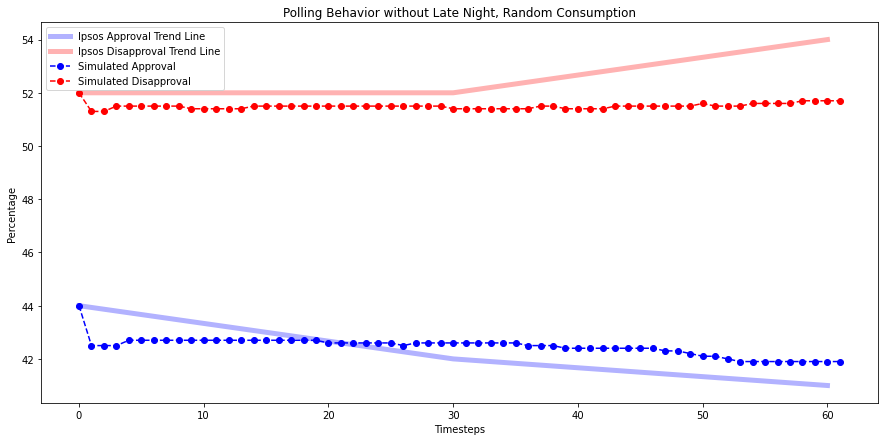

In [135]:
steps = range(62)
plt.figure(figsize=(15, 7))
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)

approval = np.concatenate((NLN_period1, NLN_period2))

plt.plot(steps, approval[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
plt.plot(steps, approval[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
plt.legend()
plt.show()

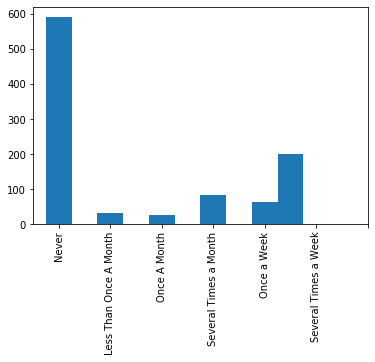

In [97]:
#Late night mock up

#Could also do this by approval of trump. That might feel more accurate
'''Watch Late Night? HR1_1 by PID
      Yes.   No
Dem   54.    46
Ind   34.    66
Rep   26.    74


How often? (Of those who said yes) HR2 by PID
      Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
Dem.     51             18.           15.            5.               6.            5
Ind      35.            17.           22.            10.              9.            7
Rep      35.            18.           20             10               12            5




///////////////Same things but by approval instead///////////////
but there is no 'No Opinion' option :/


'''

pids = np.array([agent.ideology for agent in model.agents])
dems = np.where(pids == 'democrat')[0]
inds = np.where(pids == 'independent')[0]
reps  = np.where(pids == 'republican')[0]

dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

LN_dems = np.where(dems_watch_LN)[0]
LN_inds = np.where(inds_watch_LN)[0]
LN_reps = np.where(reps_watch_LN)[0]

LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .17, .22, .10, .09, .07])

for d in LN_dems: model.agents[d].late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
for i in LN_inds: model.agents[i].late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
for r in LN_reps: model.agents[r].late_night = LN_reps_watch_amount[list(LN_reps).index(r)]
    
plt.hist([agent.late_night for agent in model.agents])
plt.xticks([0.25 + i for i in range(7)], labels=['Never', 'Less Than Once A Month', 'Once A Month', 'Several Times a Month', 'Once a Week', "Several Times a Week"], rotation='vertical')
plt.show()

In [99]:
model.agents[np.random.randint(len(model.agents))].stats()

Ideology: democrat
Approval: strongly disapprove
Primary Platform for News: Major Network or Radio
	Major Sources: NPR, 
	Minor Sources: CNN, Politico, 
Watches Late-Night: Never


In [46]:
LN_dems_watch_amount

array([0, 4, 5, 0, 3, 3, 5, 0, 5, 5, 4, 2, 5, 4, 5, 5, 1, 5, 5, 5, 3, 5,
       5, 3, 3, 5, 4, 1, 5, 5, 0, 5, 5, 5, 3, 3, 4, 5, 2, 5, 5, 4, 5, 5,
       0, 4, 5, 5, 3, 4, 5, 3, 5, 5, 5, 4, 4, 5, 5, 5, 1, 5, 3, 4, 5, 4,
       5, 2, 1, 5, 5, 3, 5, 5, 5, 5, 5, 2, 5, 1, 5, 5, 3, 3, 5, 3, 1, 5,
       0, 5, 5, 5, 5, 5, 3, 5, 5, 2, 3, 4, 5, 5, 4, 4, 1, 5, 2, 1, 5, 5,
       1, 5, 4, 3, 3, 2, 5, 5, 5, 1, 4, 5, 2, 5, 5, 4, 1, 1, 5, 5, 5, 3,
       5, 4, 5, 5, 3, 3, 5, 5, 4, 5, 5, 5, 1, 3, 1, 5, 5, 5, 5, 5, 3, 5,
       3, 1, 5, 5, 3, 5, 5, 3, 3, 5, 5, 3, 2, 5, 5, 5, 3, 5, 5, 0, 5, 4,
       4, 3, 2, 5, 0, 5, 4, 5, 4, 3, 3, 4, 3, 5, 5, 4, 3, 5, 3, 3, 3, 3,
       4, 5, 4, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 4, 0, 1, 3, 4,
       4, 5, 4, 5, 4, 3, 3, 5, 5, 4, 3, 2, 3, 5, 5, 4, 3, 4, 5, 5, 5, 5,
       5, 4, 5])

In [627]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

polling_target = [34, 15, 11, 35, 6]
model_args = (1000, [29, 25, 37], 
            [[2,	76,	27],
            [2,     12,	19],
            [11,	6,	14],
            [84,	5,	34],
            [1, 	2,	6]], media_outlets)


m = Model(*model_args, distribution_threshold=0.5)
def f(x):
    (threshold, alpha, persuadability_scale) = (0.15, 0.01, 1/10)
    coverage_leaning = x
    result = m.simulate(30, optimize=True, threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning)
    loss = 0
    for i, r in enumerate(result):
        loss += abs(r - polling_target[i])**2
    loss /= len(result)
    print(f"\rloss: {np.round(loss, 4)}, coverage_leaning: {x}", end='')
    #print(f"loss: {np.round(loss, 4)}, thresh: {np.round(threshold, 4)}, alpha: {np.round(alpha, 4)}, persuadability_scale: {np.round(persuadability_scale, 4)}")
    return loss
    
c = np.linspace(-3, 3, 100)

loss = np.zeros((c.shape))
for i, val in enumerate(c):
    loss[i] = f(val)

loss: 331.508, coverage_leaning: -1.9090909090909092

KeyboardInterrupt: 

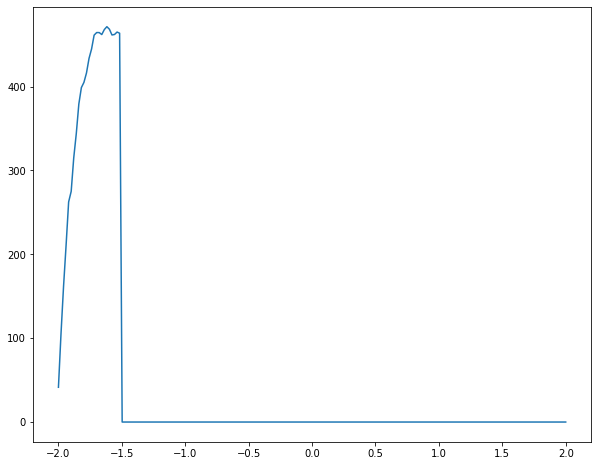

In [625]:
fig = plt.figure( figsize=(10,8) )
plt.plot(c, loss)
#ax = fig.add_subplot(1 , 1, 1, projection='3d')
#ax.contour(p, alpha, loss ,cmap=cm.gnuplot)
#ax.set_xlabel("Persuadability Scale")
#ax.set_ylabel("Alpha")
#ax.set_zlabel("Loss")

In [622]:
print(np.where(loss == np.min(loss)))
np.min(loss)

(array([0]),)


42.872

In [107]:
s = 0
for media in media_outlets:
    s += media.mcb_ideology[0]

In [108]:
arr = [media.mcb_ideology[0]/s for media in media_outlets]

In [109]:
arr

[0.12470588235294118,
 0.07764705882352942,
 0.02823529411764706,
 0.09411764705882353,
 0.08705882352941176,
 0.07764705882352942,
 0.0611764705882353,
 0.07294117647058823,
 0.03294117647058824,
 0.023529411764705882,
 0.018823529411764704,
 0.07058823529411765,
 0.05176470588235294,
 0.03529411764705882,
 0.03058823529411765,
 0.018823529411764704,
 0.01647058823529412,
 0.05411764705882353,
 0.002352941176470588,
 0.011764705882352941,
 0.004705882352941176,
 0.002352941176470588,
 0.001176470588235294,
 0.001176470588235294]

In [87]:
for i in model.agent_political_ids:
    print(np.array(CNN.mcb_ideology)[(i.reshape(-1, 1) * CNN.mcb_ideology).nonzero()], end='\n\n')

IndexError: too many indices for array

In [188]:
#ABC, CBS, or NBC
national = MediaOutlet("ABC, CBS, or NBC", [0, 0, 1, 0, 0], [[19, 37, 43],
                                                            [35, 40, 24],
                                                            [55, 30, 15],
                                                            [40, 39, 21]])
CNN =  MediaOutlet("CNN", [1, 0, 0, 0, 0], [[6, 24, 69],
                                           [17, 33, 50],
                                           [42, 34, 24],
                                           [42,	34, 24]])

FoxNews = MediaOutlet("Fox News", [0, 0, 0, 0, 1], [[37, 38, 25],
                                                   [25,	37, 37],
                                                   [18,	33, 49],
                                                   [8, 22, 70]])

MSNBC = MediaOutlet("MSNBC", [1, 0, 0, 0, 0], [[3,	20, 77],
                                              [11,	28,	60],
                                              [27,	33,	40],
                                              [27,	33,	40]])

NPR = MediaOutlet("NPR", [0, 0, 1, 0, 0], [[3,	16,	81],
                                          [7,	19,	74],
                                          [19,	24,	57],
                                          [30,	28,	42]])

NewYorkTimes = MediaOutlet("New York Times", [0, 1, 0, 0, 0], [[3,	18,	79],
                                                              [9,	25,	66],
                                                              [22,	32,	46],
                                                              [29,	36,	35]])

HannityLimbaugh = MediaOutlet("Hannity and Limbaugh", [0, 0, 0, 0, 1], [[25,	30,	44],
                                                                       [9,	21,	70],
                                                                       [7,	14,	78],
                                                                       [2,	7,	90]])

WashingtonPost = MediaOutlet("Washington Post", [0, 1, 0, 0, 0], [[3,	18,	80],
                                                                 [6,	23,	71],
                                                                 [18,	31,	51],
                                                                 [19,	40,	40]])

new_media_outlets = [national, CNN, FoxNews, MSNBC, NPR, NewYorkTimes, HannityLimbaugh, WashingtonPost]

In [189]:
                    '''political_leaning, mcb_ideology'''
FoxNews = MediaOutlet("Fox News", [0, 0, 0, 1, 0], [39, 23, 60])
CNN = MediaOutlet("CNN", [1, 0, 0, 0, 0], [39, 53, 24])
NBC = MediaOutlet("NBC", [0, 1, 0, 0, 0], [34, 40, 28])
ABC = MediaOutlet("NBC", [0, 1, 0, 0, 0], [33, 37, 30])
CBS = MediaOutlet("CBS", [0, 1, 0, 0, 0], [30, 33, 26])
MSNBC = MediaOutlet("MSNBC", [1, 0, 0, 0, 0], [24, 33, 14])
NPR = MediaOutlet("NPR", [0, 0, 1, 0, 0], [20, 30, 11])
NewYorkTimes = MediaOutlet("New York Times", [0, 1, 0, 0, 0], [20, 31, 9])
WashingtonPost = MediaOutlet("Washington Post", [0, 1, 0, 0, 0], [17, 26, 8])
#PBS 16%
BBC = MediaOutlet("BBC", [0, 0, 1, 0, 0], [16, 22, 10])
WallStreetJournal = MediaOutlet("Wall Street Journal", [0, 0, 1, 0, 0], [13, 15, 11])
USAToday = MediaOutlet("USA Today", [0, 0, 1, 0, 0], [11, 13, 10])
Politico = MediaOutlet("Politico", [0, 1, 0, 0, 0], [9, 14, 5])
HuffPost = MediaOutlet("HuffPost", [1, 0, 0, 0, 0], [8, 12, 3])
Limbaugh = MediaOutlet("Limbaugh", [0, 0, 0, 0, 1], [8, 1, 17])#made up
BuzzFeed = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [7, 9, 5])
Time = MediaOutlet("Time", [0, 1, 0, 0, 0], [7, 10, 4])
TheHill = MediaOutlet("The Hill", [0, 0, 1, 0, 0], [6, 8, 5])




Vox = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [8, 8, 1, 1])








TheGuardian = MediaOutlet("The Guardian", [0, 1, 0, 0, 0], [8, 8, 3, 3])






Newsweek = MediaOutlet("Newsweek", [0, 0, 1, 0, 0], [7, 7, 3, 3])


Hannity = MediaOutlet("Hannity", [0, 0, 0, 1, 0], [1, 1, 19, 19])#made up
NewYorkPost = MediaOutlet("New York Post", [0, 0, 0, 1, 0], [5, 5, 5, 5])
WashingtonExaminer = MediaOutlet("WashingtonExaminer", [0, 0, 0, 1, 0], [2, 2, 4, 4])


Breitbart = MediaOutlet("Breitbart", [0, 0, 0, 0, 1], [0.5, 0.5, 8, 8])
DailyCaller = MediaOutlet("Daily Caller", [0, 0, 0, 0, 1], [0.5, 0.5, 3, 3])


_media_outlets = [CNN, MSNBC, HuffPost, BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

In [ ]:
            
            
            
#     def assign_media(self):
#         '''https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
#             One source.    Multiple Sources
#         D      28.                63
        
#         R      38                 53
        
        
#         https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
#         Also, 53% of adults get news from social media often or sometimes
        
        
        
#         Those that closely read an article or watch a program
#         More    Once    Less    Never     in a day
#         39% 	29% 	30% 	2%
#          |       |       |      |
#          V       V       V      V
#          1.5     1       .5     0         percentages * 100
        
#         to implement this we want to assign this percentage of agents to each frequency, then when choosing a source to cconsume during simulate, we 
#         use these chances to decide if the current agent will consume, then if so, we pick a random source to consume??
        
#         if this doesn't work, we could also implement the headlines frequency with a limited effect or even the same effect I guess
        
#         just building in survey data now i guess :/ '''
        
        
#         dems = np.where((self.agent_political_ids == [1, 0, 0, 0]).all(axis=1) | (self.agent_political_ids == [0, 1, 0, 0]).all(axis=1) )[0]
#         d_number_of_sources = np.random.choice([0, 1], size=len(dems), p=[0.28+0.03, 0.63+0.06])
#         d_one_source = dems[np.where(d_number_of_sources == 0)[0]]
#         d_mult_source = dems[np.where(d_number_of_sources == 1)[0]]
        
#         reps = np.where((self.agent_political_ids == [0, 0, 0, 1]).all(axis=1) | (self.agent_political_ids == [0, 0, 1, 0]).all(axis=1) )[0]
#         r_number_of_sources = np.random.choice([0, 1], size=len(reps), p=[0.38+0.04, 0.53+0.05])
#         r_one_source = reps[np.where(r_number_of_sources == 0)[0]]
#         r_mult_source = reps[np.where(r_number_of_sources == 1)[0]]
        
#         one_source = np.concatenate((d_one_source, r_one_source))
#         del d_one_source, r_one_source
        
#         to_consume = np.zeros((len(self.media_array), 2))
#         for i, media in enumerate(self.media_array):
#             #the number of dems and reps that conusme this media
#             to_consume[i, 0] = int(np.round(media.mcb_ideology[0] * len(dems) / 100))
#             to_consume[i, 1] = int(np.round(media.mcb_ideology[-1] * len(reps) / 100))
        
#         #this is the order the rows in the platform split need to be in
#         parties = [dems, reps]
    
#         sum_of_dem_percents = 0
#         for media in self.media_array: sum_of_dem_percents += media.mcb_ideology[0]
#         weighted_dem_percents = [media.mcb_ideology[0]/sum_of_dem_percents for media in self.media_array]
        
#         sum_of_rep_percents = 0
#         for media in self.media_array: sum_of_rep_percents += media.mcb_ideology[-1]
#         weighted_rep_percents = [media.mcb_ideology[-1]/sum_of_rep_percents for media in self.media_array]
        
#         del sum_of_rep_percents, sum_of_dem_percents
        
#         weighted_percents = [weighted_dem_percents, weighted_rep_percents]
        
#         for i, row in enumerate(self.platform_split):
#             net = int(len(parties[i]) * row[0]/100)
#             social = int(len(parties[i]) * row[1]/100)
#             rest = len(parties[i]) - net - social

#             #Major Network or Radio
#             for _ in range(net):
#                 agent_index = np.random.choice(parties[i])
#                 parties[i] = np.delete(parties[i], np.where(parties[i] == agent_index)[0])
#                 self.agents[agent_index].platform = 'Major Network or Radio'
#                 #now choose from media array
#                 while True:
                    
#                     media_index = np.random.choice(range(len(self.media_array)), p=weighted_percents[i])#np.random.randint(len(self.media_array))
#                     if to_consume[media_index, i] > 0:
#                         to_consume[media_index, i] -= 1
#                         self.agents[agent_index].major_sources.append(self.media_array[media_index])
#                         break
                    
#                 #can add chance for more here
#                 if agent_index in one_source:
#                     while True:
#                         media_index = np.random.choice(range(len(self.media_array)), p=weighted_percents[i])
#                         if to_consume[media_index, i] > 0:
#                             to_consume[media_index, i] -= 1
#                             self.agents[agent_index].major_sources.append(self.media_array[media_index])
#                             break
#             #Social Media
#             for _ in range(social):
#                 agent_index = np.random.choice(parties[i])
#                 parties[i] = np.delete(parties[i], np.where(parties[i] == agent_index)[0])
#                 self.agents[agent_index].platform = 'Social Media'
#                 self.agents[agent_index].uses_social_media = True
#                 #now assign social media as major platform
#                 self.agents[agent_index].major_sources.append('Social Media')
                
#             #The rest
#             for _ in range(rest):
#                 agent_index = np.random.choice(parties[i])
#                 parties[i] = np.delete(parties[i], np.where(parties[i] == agent_index)[0])
#                 self.agents[agent_index].platform = np.random.choice(['Major Network or Radio', 'Social Media'])
                
#                 if self.agents[agent_index].platform == 'Major Network or Radio':
#                     while True:
#                         media_index = np.random.choice(range(len(self.media_array)), p=weighted_percents[i])
#                         if to_consume[media_index, i] > 0:
#                             to_consume[media_index, i] -= 1
#                             self.agents[agent_index].major_sources.append(self.media_array[media_index])
#                             break
#                 else:
#                     self.agents[agent_index].major_sources.append('Social Media')
#                     self.agents[agent_index].uses_social_media = True

#         #now assign the remaining media as minor sources
#         for i, media_amounts in enumerate(to_consume):
#             #separate agents that have this source as a major source already
#             sep_dems = [index for index in dems if self.media_array[i] not in self.agents[index].major_sources]
#             sep_reps = [index for index in reps if self.media_array[i] not in self.agents[index].major_sources]
#             d = np.random.choice(sep_dems, size=int(media_amounts[0]), replace=False)
#             r = np.random.choice(sep_reps, size=int(media_amounts[1]), replace=False)
#             for j in d: self.agents[j].minor_sources.append(self.media_array[i])
#             for k in r: self.agents[k].minor_sources.append(self.media_array[i])
        
#         #now I need to finish social media assignments to complete percentages
#         count = np.sum([1 for agent in self.agents if 'Social Media' in agent.major_sources])
        
#         #this is just straight from data
#         total = int(len(self.agents) * 0.53) - count
        
#         sm_indices = np.random.choice(np.where(['Social Media' not in agent.major_sources for agent in self.agents])[0], total, replace=False)
        
#         for index in sm_indices:
#             self.agents[index].minor_sources.append('Social Media')
#             self.agents[agent_index].uses_social_media = True
        
        
